In [15]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
def generate_value(normal_range, abnormal_range):
    """Generates a normal or abnormal value randomly."""
    if random.random() < 0.7:
        return round(random.uniform(*normal_range), 2)
    else:
        return round(random.uniform(*abnormal_range), 2)

def is_normal(ecg, pressure, temperature, bpm, fetal_count):
    """Determines if the overall status is Normal or Abnormal."""
    if (110 <= ecg <= 160 and
        110 <= pressure <= 130 and
        36.4 <= temperature <= 37.2 and
        60 <= bpm <= 100 and
        fetal_count > 4):
        return "Normal"
    return "Abnormal"

def generate_dataset(num_samples=1000):
    data = []
    for _ in range(num_samples):
        ecg = generate_value((110, 160), (50, 100)) if random.random() < 0.5 else generate_value((110, 160), (161, 200))
        pressure = generate_value((110, 130), (80, 109)) if random.random() < 0.5 else generate_value((110, 130), (131, 180))
        temperature = generate_value((36.4, 37.2), (35, 36.3)) if random.random() < 0.5 else generate_value((36.4, 37.2), (37.3, 40))
        bpm = generate_value((60, 100), (30, 59)) if random.random() < 0.5 else generate_value((60, 100), (101, 180))
        fetal_count = random.randint(0, 10)
        status = is_normal(ecg, pressure, temperature, bpm, fetal_count)
        
        data.append([ecg, pressure, temperature, bpm, fetal_count, status])
    
    df = pd.DataFrame(data, columns=["ECG", "Pressure", "Temperature", "BPM", "FetalCount", "Status"])
    return df

# Generate dataset and save to CSV
dataset = generate_dataset(1000)
dataset.to_csv("fetal_data.csv", index=False)

print("Dataset generated and saved as fetal_data.csv")


Dataset generated and saved as fetal_data.csv


In [17]:
# Load dataset
dataset = pd.read_csv("fetal_data.csv")

In [18]:
# Ensure proper column names and data types
columns_needed = ["ECG", "Pressure", "Temperature", "BPM", "FetalCount", "Status"]
dataset = dataset[columns_needed]

dataset["Status"] = dataset["Status"].map({"Normal": 1, "Abnormal": 0})

X = dataset.drop(columns=["Status"])
y = dataset["Status"]

In [19]:
# Handle class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [21]:
# Define models and reduced parameter grids
models = {
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [100], "max_depth": [None, 10]}),
    "SVM": (SVC(probability=True), {"C": [1, 10], "kernel": ["linear"]})
}

best_model = None
best_score = 0
history = {}

In [22]:
# Train models using RandomizedSearchCV and save the best one
for model_name, (model, param_grid) in models.items():
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    history[model_name] = {
        "train_score": grid_search.cv_results_["mean_train_score"],
        "test_score": grid_search.cv_results_["mean_test_score"]
    }

    print(f"Classification Report for {model_name}:")
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_model_name = model_name

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       181
           1       0.99      0.99      0.99       165

    accuracy                           0.99       346
   macro avg       0.99      0.99      0.99       346
weighted avg       0.99      0.99      0.99       346

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.83      0.61      0.70       181
           1       0.67      0.87      0.75       165

    accuracy                           0.73       346
   macro avg       0.75      0.74      0.73       346
weighted avg       0.75      0.73      0.73       346



In [23]:
# Save the best model
model_filename = f"best_fetal_model.pkl"
joblib.dump(best_model, model_filename)
print("Best model trained using fetal_data.csv and saved as best_fetal_model.pkl")
print(f"Selected Best Model: {best_model_name}")

Best model trained using fetal_data.csv and saved as best_fetal_model.pkl
Selected Best Model: RandomForest


In [29]:
# Evaluate the models
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       181
           1       0.99      1.00      1.00       165

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346



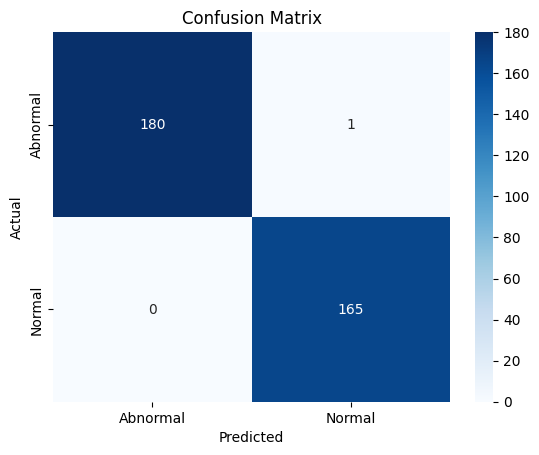

In [25]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

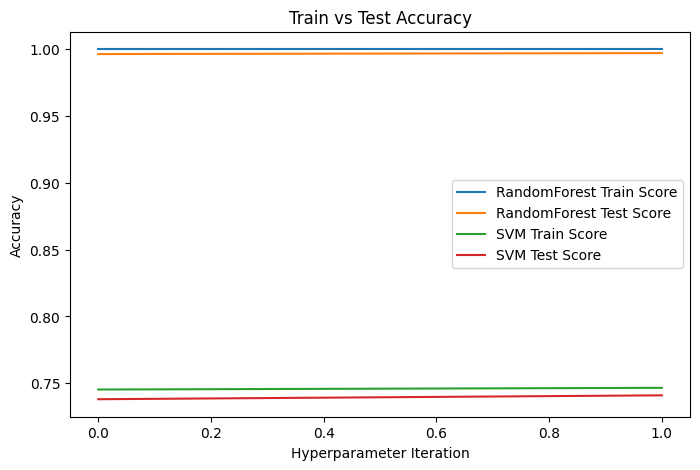

In [26]:
# Plot training loss (Train vs Test scores)
plt.figure(figsize=(8, 5))
for model_name, scores in history.items():
    plt.plot(scores["train_score"], label=f'{model_name} Train Score')
    plt.plot(scores["test_score"], label=f'{model_name} Test Score')
plt.xlabel("Hyperparameter Iteration")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.show()

Inferance

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load the saved model for prediction
model_filename = f"best_fetal_model.pkl"
loaded_model = joblib.load(model_filename)

In [5]:
# Sample input data for prediction
sample_data = np.array([[120.5, 125.3, 36.8, 80.2, 5]])  # Example values
prediction = loaded_model.predict(sample_data)
prediction_label = "Normal" if prediction[0] == 1 else "Abnormal"
print(f"Prediction for sample input {sample_data}: {prediction_label}")

Prediction for sample input [[120.5 125.3  36.8  80.2   5. ]]: Normal
